#### Load and Resample Dataset

The code below loads the data from Google Drive and resamples the data with {x} Hz.

In [ ]:
# Google drive path
jump_train= "1WC6G0WINg5fvd-rwsjCyZMK8pcLkLmok"
jump_r_train= "1YGRsabtyqsTP0txUZmQ5Tv-X8jsk_lpr"
jump_test= "1hK0m1_pR_KB_sUHgd5wesRg-zX-Co0Ti"

x_train= "1N8xw0GY9s47LC5AP4tS6Lq9gqmurK_n2"
x_r= "1u4HjsO6iEIj6Alv3RuAxAoDszwWzoFfu"
x_test= "1an_P0nNPkkdpeugLVzVo_vqfnZBKNEF-"

back_train= "1Vs232s_qL9Np-GGP4b45BG_nT-OOkvNb"
back_r_train= "1-hrXhDSOnoUJtjD4ELnXGe3Xlh19y4bD"
back_test= "1-gfbdrNUxz0QENcqEo9m_Itdr9L3cKA5"

double_train= "17E86CiMX6nIkGV9wYhO5YG6S5dkUhYF6"
double_r_0= "1bLd7vdM8vwtdPtoXFaJdmBRsOdUsn_V5"
double_r_1= "1pUzhf8lUjZigaDHZC6nn37JqZfy27_mi"
double_test= "1XablBdqIJUMf5gQJR0RTeQkLH93LVXj5"

In [ ]:
from urllib.request import urlopen
import numpy as np
import pandas as pd

# use this one for reading from google drive
load_data = lambda x: pd.read_csv(
    urlopen(f'https://drive.google.com/uc?export=download&id={x}')
).assign(
    timestamp=lambda x: pd.TimedeltaIndex(x['timestamp'], unit='ms')
).set_index(
    'timestamp'
).resample(
    '30ms'
).nearest().values

# data include left hand and right hand case
NORMAL_DATA = np.append(np.append(load_data(jump_train), load_data(jump_r_train), axis=0), load_data(jump_test), axis=0)
X_DATA = np.append(np.append(load_data(x_train), load_data(x_r), axis=0), load_data(x_test), axis=0)
BACK_DATA = np.append(np.append(load_data(back_train), load_data(back_r_train), axis=0), load_data(back_test), axis=0)
DOUBLE_DATA = np.append(np.append(np.append(load_data(double_train), load_data(double_r_0), axis=0), load_data(double_r_1), axis=0), load_data(double_test), axis=0)

[(0, 0, 1), (0, 0.5, 0), (1, 0, 0), (0, 0.75, 0.75), (0.75, 0, 0.75), (0.75, 0.75, 0), (0, 0, 0), (1, 1, 1)]


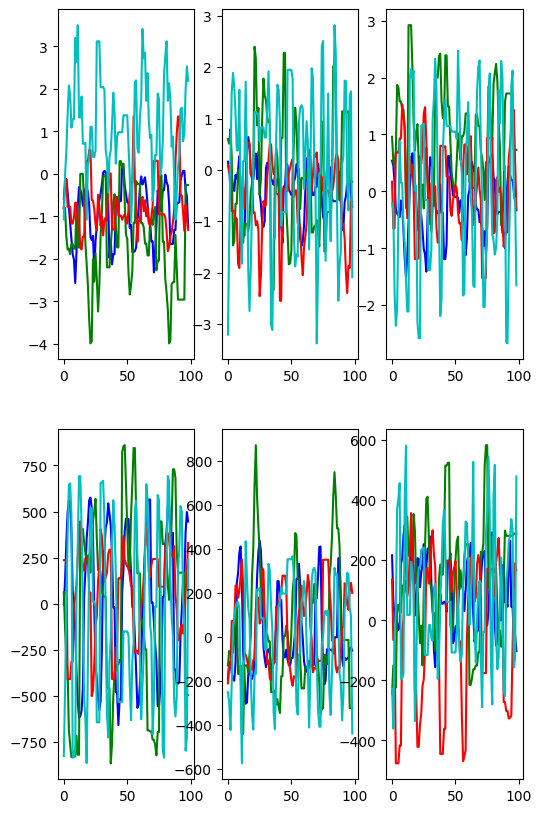

In [ ]:
# visualize the given data, can be used to check data quality
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import random
plt.figure(figsize=(6,10))
color = list(mcolors.BASE_COLORS.values())
print(color)
for j, data in enumerate([NORMAL_DATA, X_DATA, BACK_DATA, DOUBLE_DATA]):
  a = random.randint(0, 10)
  for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.plot(data[a*33:33*(a+3), i], color=color[j])
plt.show()

In [ ]:
# based on the minimum length of each class data, set the data length
import math
HZ = 33
train_size = 3000
for data in [NORMAL_DATA, X_DATA, BACK_DATA, DOUBLE_DATA]:
  train_size = min(train_size, math.floor(data.shape[0]/HZ-2))

#### K-Fold Validation (K=10)

Here, we will use data for first {x} jumps as training data and remainings as test data.

In [ ]:
import numpy as np
import random

random.seed(1004)

HZ = 33
X, y = [], []

# Apply sliding window, add labels in integer
for l, d in zip([0, 1, 2, 3], [NORMAL_DATA, X_DATA, BACK_DATA, DOUBLE_DATA]): # Label: 0 - Normal, 1 - X, 2 - Back, 3 - Double
    count = 0
    for i in np.arange(0, train_size, 0.25):
        s, e = int(i * HZ), int((i + 2) * HZ)
        X.append(d[s:e, :])
        count += 1
    y.append(np.repeat(l, count))

X, y = np.asarray(X), np.concatenate(y, axis=0)

# For dividing into folds, make empty lists
train_idxs = []
test_idxs = []

# Dividing the whole data into 10 folds
for fold in range(10):
    mother_set = set(range(y.shape[0]))
    for test_idx in test_idxs:
      mother_set -= set(test_idx)

    test_idx = random.sample(list(mother_set), (int) (y.shape[0] / 10))
    test_idx = sorted(test_idx)

    train_idx = list(set(range(y.shape[0])) - set(test_idx))
    train_idx = sorted(train_idx)

    train_idxs.append(train_idx)
    test_idxs.append(test_idx)

In [ ]:
from tensorflow import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Initialization for statistics
accs = []
precisions = []
recalls = []
f1s = []

# Validate each fold
for fold_num, (train_idx, test_idx) in enumerate(zip(train_idxs, test_idxs)):
  X_train, X_test = X[train_idx], X[test_idx]
  y_train, y_test = y[train_idx], y[test_idx]

  print(f'X_train: {X_train.shape}')
  print(f'X_test: {X_test.shape}')
  print(f'y_train: {y_train.shape}')
  print(f'y_test: {y_test.shape}')

  # define the model
  model = keras.models.Sequential([
    keras.layers.InputLayer(input_shape=(66, 6)),
    keras.layers.Conv1D(
        filters=4, kernel_size=8, strides=1,padding = "same",
        kernel_initializer=keras.initializers.HeNormal(seed=1004),
    ),
    keras.layers.MaxPooling1D(
        pool_size=4
    ),
    keras.layers.BatchNormalization(),
    keras.layers.Activation(keras.activations.relu),
    keras.layers.Flatten(),
    keras.layers.Dropout(
        rate = .5,
    ),
    keras.layers.Dense(
        units = 4, # Normal jump, Backward jump, Cross jump, Double jump
        activation=keras.activations.softmax,
        kernel_initializer=keras.initializers.GlorotUniform(seed=1004),
    )
  ])

  # compile the model
  model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=[
            keras.metrics.SparseCategoricalAccuracy(),
    ]
  )

  # train the model for this fold
  model.fit(
      x=X_train,
      y=y_train,
      validation_data=(X_test, y_test),
      batch_size=32,
      epochs=85,
  )

  # Statistics for validation
  y_pred = np.argmax(model.predict(X_test), axis=1)
  acc, precision, recall, f1 = accuracy_score(y_test, y_pred), precision_score(y_test, y_pred, average='weighted'), recall_score(y_test, y_pred, average='weighted'), f1_score(y_test, y_pred, average='weighted')

  print(f'[{fold_num}] Accuracy: {acc * 100:.2f} %.')
  print(f'[{fold_num}] Precision: {precision * 100:.2f} %.')
  print(f'[{fold_num}] Recall: {recall * 100:.2f} %.')
  print(f'[{fold_num}] F1: {f1 * 100:.2f} %.')

  # Store statistics
  accs.append(acc)
  precisions.append(precision)
  recalls.append(recall)
  f1s.append(f1)

X_train: (1354, 66, 6)
X_test: (150, 66, 6)
y_train: (1354,)
y_test: (150,)
Epoch 1/85
43/43 [==============================] - 2s 20ms/step - loss: 1.9334 - sparse_categorical_accuracy: 0.2149 - val_loss: 2.0766 - val_sparse_categorical_accuracy: 0.1733
Epoch 2/85
43/43 [==============================] - 0s 9ms/step - loss: 1.6517 - sparse_categorical_accuracy: 0.2888 - val_loss: 1.5651 - val_sparse_categorical_accuracy: 0.2467
Epoch 3/85
43/43 [==============================] - 0s 11ms/step - loss: 1.4592 - sparse_categorical_accuracy: 0.3368 - val_loss: 1.3290 - val_sparse_categorical_accuracy: 0.3200
Epoch 4/85
43/43 [==============================] - 0s 6ms/step - loss: 1.2952 - sparse_categorical_accuracy: 0.4106 - val_loss: 1.1873 - val_sparse_categorical_accuracy: 0.3933
Epoch 5/85
43/43 [==============================] - 0s 6ms/step - loss: 1.1583 - sparse_categorical_accuracy: 0.4764 - val_loss: 1.0878 - val_sparse_categorical_accuracy: 0.4933
Epoch 6/85
43/43 [==============

#### Evaluation
Now with K-Fold validation data, evaluate our model.

In [ ]:
tot_acc, tot_precision, tot_recall, tot_f1 = 0.0, 0.0, 0.0, 0.0
cnt = 0

print("Accuracy | Precision | Recall | F1")

# Print each result
for fold_num, (acc, precision, reacll, f1) in enumerate(zip(accs, precisions, recalls, f1s)):
  cnt += 1
  tot_acc += acc
  tot_precision += precision
  tot_recall += recall
  tot_f1 += f1

  print(f"[{fold_num}] {acc * 100:.2f} %, {precision * 100:.2f} %, {recall * 100:.2f} %, {f1 * 100:.2f} %")

# Calculate the average
tot_acc /= cnt
tot_precision /= cnt
tot_recall /= cnt
tot_f1 /= cnt

# Print the average
print(f"[Total] {tot_acc * 100:.2f} %, {tot_precision * 100:.2f} %, {tot_recall * 100:.2f} %, {tot_f1 * 100:.2f} %")

Accuracy | Precision | Recall | F1
[0] 97.33 %, 97.47 %, 98.00 %, 97.32 %
[1] 97.33 %, 97.64 %, 98.00 %, 97.37 %
[2] 98.00 %, 98.14 %, 98.00 %, 98.00 %
[3] 98.67 %, 98.70 %, 98.00 %, 98.65 %
[4] 96.00 %, 96.27 %, 98.00 %, 95.95 %
[5] 98.67 %, 98.70 %, 98.00 %, 98.67 %
[6] 98.00 %, 98.04 %, 98.00 %, 97.99 %
[7] 100.00 %, 100.00 %, 98.00 %, 100.00 %
[8] 98.00 %, 98.04 %, 98.00 %, 97.99 %
[9] 98.00 %, 98.18 %, 98.00 %, 98.02 %
[Total] 98.00 %, 98.12 %, 98.00 %, 98.00 %
